### Neurala Nätverk är modeller för Allmän Linjär Regression 

<img src="../Data/mlpnn.jpg">

$\hat{Y} = \varphi (\mathbf{XW} + \mathbf{b})$

att jämföra med

$\hat{Y} = \beta_0 + \beta_1X_1 …$

Varje $x_i w_{ij} + b_i$ är alltså en linje! Om aktiveringsfunktionen är linjär, så är hela systemet verkligen "bara" en multipel linjär regression.

Flera lager ger i princip en polynomiell regression, men viktigt är att inse att varje lager tar förra lagrets aktivering som input-- så det är djupa interaktionseffekter med avseende på featuremängden, som inte är enkla att skriva ner som polynom. Om det finns cykler eller genvägar i nätverket är det inte längre möjligt att skriva ner som ett polynom (det är då en iterativ serie, som kan vara kaotisk; jmf logistiska avbildningen $x_{n+1} = rx_n(1-x_n)$).

### Ickelinjäritet

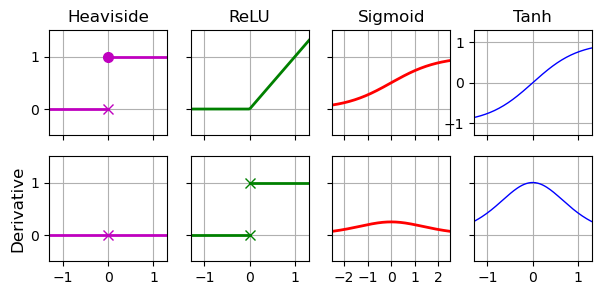

In [1]:
# activation functions
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps)) / (2 * eps)

max_z = 2.5
z = np.linspace(-max_z, max_z, 200)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(7, 3))

axes[0, 0].plot([-max_z, 0], [0, 0], "m-", linewidth=2)
axes[0, 0].plot(0, 0, "mx", markersize=7)
axes[0, 0].plot(0, 1, "mo", markersize=7)
axes[0, 0].plot([0, max_z], [1, 1], "m-", linewidth=2)
axes[0, 0].set_title("Heaviside", fontsize=12)
axes[1, 0].plot(z, derivative(np.sign, z), "m-", linewidth=2)
axes[1, 0].plot(0, 0, "mx", markersize=7)
axes[1, 0].set_ylabel("Derivative", fontsize=12)

axes[0, 1].plot(z, relu(z), "g-", linewidth=2)
axes[0, 1].set_title("ReLU", fontsize=12)
axes[1, 1].plot([-max_z, 0], [0, 0], "g-", linewidth=2)
axes[1, 1].plot([0, max_z], [1, 1], "g-", linewidth=2)
axes[1, 1].plot(0, 0, "gx", markersize=7)
axes[1, 1].plot(0, 1, "gx", markersize=7)

axes[0, 2].plot(z, sigmoid(z), "r-", linewidth=2)
axes[0, 2].set_title("Sigmoid", fontsize=12)
axes[1, 2].plot(z, derivative(sigmoid, z), "r-", linewidth=2)

axes[0, 3].plot(z, np.tanh(z), "b-", linewidth=1)
axes[0, 3].set_title("Tanh", fontsize=12)
axes[1, 3].plot(z, derivative(np.tanh, z), "b-", linewidth=1)

for row in range(2):
    for col in range(4):
        axes[row, col].grid(True)
        if row == 0:
            axes[row, col].set_xticklabels([])
        if col == 2:
            axes[row, col].set_xlim(-max_z, max_z)
            axes[row, col].set_xticks([-2, -1, 0, 1, 2])
        else:
            axes[row, col].set_xlim(-1.3, 1.3)
            axes[row, col].set_xticks([-1, 0, 1])
        if col != 0 and ((row, col) != (0, 3)):
            axes[row, col].set_yticklabels([])
        if (row, col) == (0, 3):
            axes[row, col].set_ylim(-1.3, 1.3)
            axes[row, col].set_yticks([-1, 0, 1])
        else:
            axes[row, col].set_ylim(-0.5, 1.5)
            axes[row, col].set_yticks([0, 1])

plt.show()



Men vi löser inte detta system med statistisk anpassning. Inte minst kan vi inte hantera diskontinuerliga aktiveringsfunktioner med OLS eller MLE! Med numeriska närmevärden kommer vi undan detta, vilket är matematisk krångligt men praktiskt bekvämt.

Idéen är på ytan enkel, men matematiskt väldigt svårbegriplig! Se Appendix A i boken -- matematiken är mer än vi klarar med algebran vi lärt oss. Framör allt måste vi använda hyperkomplexa tal (_dualer_). För den hugade som inte är rädd för abstrakt algebra har Dr [Michael Penn](https://www.youtube.com/watch?v=ceaNqdHdqtg) en video om dem. Det finns andra enklare videor på youtube, men de begrepp som Dr Penn går igenom är det som faktiskt krävs för att kunna använda dem på egen hand.

I korta; dualer är en sorts tal som har "fler nollor" än vanliga tal. Specifikt finns en särskild symbol $\epsilon$ som har egenskapen $\epsilon^2 = 0$ (jämför med komplexa tal $i^2 = -1$).


<small>Överkurs <br />
En formulering i linjär algebra:
Icke-linjäritet leder till att nollrummets dimension exploderar; det finns alltså fler och fler icke-lösningar. Detta innebär att Jordan dekompositionen inte längre skulle vara nilpotent och vi hamnar i "curse of dimensionality", dvs hittar bara icke-lösningar. Med dualer avbildar vi nollrummet på ett delrum som är nilpotent! Därmed kan vi derivera även icke-kontinuerliga aktiveringsfunktioner, och hitta linjära approximationer till vad som helst i ett litet område kring testdatan! Vi kan till och med formulera det som Taylor-expansion och återsälla Kolmogorovs representationsteorem --> Universal Approximation Theorem för feed-forward NN.
</small>

Istället för att beräkna lutningen på alla linjerna separat, så uppskattar vi lutningarna (vikterna $w_{ij}$) för alla noder på en gång. Detta sker genom två pass genom nätverket: 
* I framåt riktningen beräknas alla noders värden (dvs $x_iw_{ij} + b_i$)
* I bakåt riktningen beräknas de partiella derivatorna för hela det multipla linjära systemet genom en hyperkomplex beräkningsgraf

Detta kallas <em>reverse-mode auto-diff</em>.

Nästa steg för att få en fungerande algoritm för att träna ett NN är att utföra <em>gradient descent</em>, dvs: 
* Justera vikterna $w_{ij}$ ett litet steg i den beräknade gradientens riktning. 

Upprepa!

När vi når något stopp-villkor så är vi klara. Detta kallas 'backpropagation'.

Notera att inget sades om vilken <em>sorts</em> gradient descent som används. I praktiken är <em>mini-batch gradient descent</em> det som är effektivast att köra på GPUer, men särskilt på CPU kan en sann stokastisk gradient descent (där vi alltså sätter någon sannolikhet för varje nod att vara med eller inte) vara lämplig. Detta är mindre sannolikt idag, eftersom även CPUer är väldigt parallella med dussintals, eller till och med hundratals, processorkärnor. 


Modern hårdvara är riktigt snabb, både CPU och GPU. På en AMD 7800X3D/7900GRE (en speldator som är en generation gammal och i näst högsta klassen av den generationens hårdvara) så är prestandan 8x högre för CPU och 4x snabbare för GPU än en gratisinstans på Colab (nVidia T4).

In [2]:
import torch
device = "cuda"

In [3]:
M = torch.rand((1000,1000))
M @ M.T # uppvärming; låter X3D cachen på CPU fyllas
%timeit M @ M.T

M = M.to(device)
M @ M.T # låter GDDR-cache på GPU fyllas
%timeit M @ M.T

2.03 ms ± 19.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
146 μs ± 10.1 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Att jämföra med Colab (nVidia T4): <br />
16.1 ms ± 2.17 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)<br /> 
549 µs ± 3.99 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Och en Intel Core Ultra 7 265K / nVidia RTX 4000 Ada: <br />
1.64 ms ± 771 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)<br />
222 μs ± 236 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

7900GRE visar sig i detta enkla test var mycket snabbare än en T4 (och halva priset) och även snabbare än ett RTX 4000 Ada (men en tredjedel av priset). 

Sklearn har enklare neurala nätverk, men de är ganska begränsade. Däremot är de väldigt optimerade och förkompilerade, så de prestrerar ofta bra. Låt oss undersöka dem först, och sedan börja implementera samma sak fast med pytorch. 

In [6]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [7]:
housing = fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target)

In [8]:
housing.feature_names, housing.target_names

(['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 ['MedHouseVal'])

In [9]:
# in och ut dimensioner räknas ut automatiskt! ReLU mellan dolda lager, linjärt ut och in
# early stopping för att undvika overfit
mlp_reg = MLPRegressor(hidden_layer_sizes=[50,50,50], early_stopping=True, verbose=True)

In [10]:
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)

Iteration 1, loss = 0.72128827
Validation score: 0.510060
Iteration 2, loss = 0.30131237
Validation score: 0.631138
Iteration 3, loss = 0.22955215
Validation score: 0.676511
Iteration 4, loss = 0.20245579
Validation score: 0.692050
Iteration 5, loss = 0.19035141
Validation score: 0.715338
Iteration 6, loss = 0.18057593
Validation score: 0.729605
Iteration 7, loss = 0.17363693
Validation score: 0.738896
Iteration 8, loss = 0.16898907
Validation score: 0.742349
Iteration 9, loss = 0.16396961
Validation score: 0.744340
Iteration 10, loss = 0.16039636
Validation score: 0.753197
Iteration 11, loss = 0.15783175
Validation score: 0.756524
Iteration 12, loss = 0.15415837
Validation score: 0.763000
Iteration 13, loss = 0.15147692
Validation score: 0.761251
Iteration 14, loss = 0.14947244
Validation score: 0.767436
Iteration 15, loss = 0.14772164
Validation score: 0.766197
Iteration 16, loss = 0.14548381
Validation score: 0.768979
Iteration 17, loss = 0.14311424
Validation score: 0.767677
Iterat

,steps,"[('standardscaler', ...), ('mlpregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,loss,'squared_error'
,hidden_layer_sizes,"[50, 50, ...]"
,activation,'relu'
,solver,'adam'


In [11]:
mlp_reg.best_validation_score_

0.8005282019458779

In [12]:
y_pred = pipeline.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)

In [13]:
rmse

0.5375518084472941

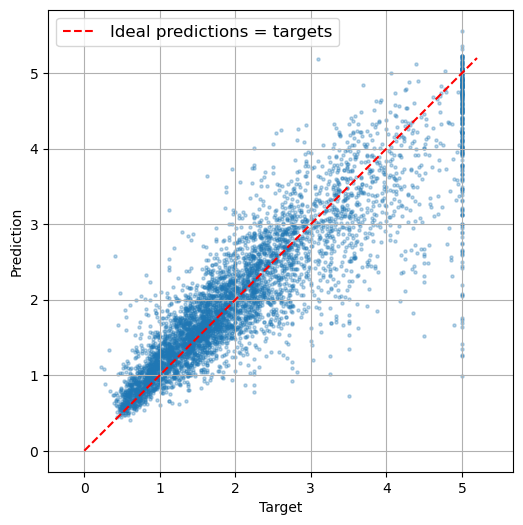

In [14]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, s=5, alpha=0.3)
plt.plot([0, 5.2], [0,5.2], color='red', linestyle='--', label="Ideal predictions = targets")
plt.axis("equal")
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.legend(fontsize=12)
plt.grid()
plt.show()

### Backpropagation i Torch

#### Autograd, reverse-mode autodiff i pytorch



$f(x) = x^2$

$f(5) = 25$

$f'(x) = 2x$

$f'(5) = 10$

In [15]:
x = torch.tensor(5.0, requires_grad=True)
f = x ** 2
f

tensor(25., grad_fn=<PowBackward0>)

In [16]:
f.backward() # reverse-mode auto-diff
x.grad # f och x är kopplade tack vare requires_grad!

tensor(10.)

#### Backpropagation

In [17]:
learning_rate = 0.1 # hur stort steg vi tar
x = torch.tensor(5.0, requires_grad=True)
for iteration in range(100):
    f = x**2 # framåt passet, beräkna alla värden
    f.backward() # bakåtpasset genom beräkningsgrafen
    # gradient descent
    with torch.no_grad(): # koppla inte till gradienterna! vi vill räkna om dem senare
        x -= learning_rate * x.grad
    x.grad.zero_() # sätt gradienterna till 0 så vi räknar om från början



In [18]:
x # går mot 0, eftersom x^2 har sitt minimum där!

tensor(1.0185e-09, requires_grad=True)

### Linjär regression med pytorch

In [19]:
X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target)
print(f"Training set: {X_train.shape, y_train.shape}\nTest set: {X_test.shape, y_test.shape}")

Training set: ((15480, 8), (15480,))
Test set: ((5160, 8), (5160,))


In [20]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
means = X_train.mean(dim = 0, keepdim=True)
stds = X_train.std(dim=0, keepdims=True)
X_train = (X_train - means) / stds
X_test = (X_test - means) / stds

In [21]:
y_train = torch.FloatTensor(y_train).reshape(-1, 1)
y_test = torch.FloatTensor(y_test).reshape(-1, 1)


In [22]:
n_features = X_train.shape[1]
w = torch.randn((n_features, 1), requires_grad=True) # initialisera med slumpässiga vikter
b = torch.tensor(0., requires_grad=True)


##### Batch Gradient Descent

In [23]:
learning_rate = 0.1
n_epochs = 100
for epoch in range(n_epochs):
    y_pred = X_train @ w + b
    loss = ((y_pred - y_train)**2).mean() # MSE
    loss.backward()
    with torch.no_grad():
        b -= learning_rate * b.grad
        w -= learning_rate * w.grad
        b.grad.zero_()
        w.grad.zero_()
    print(f"Epoch {epoch +1}/{n_epochs}, Loss: {loss.item()}")


Epoch 1/100, Loss: 9.69684886932373
Epoch 2/100, Loss: 5.611098766326904
Epoch 3/100, Loss: 3.5220377445220947
Epoch 4/100, Loss: 2.3717219829559326
Epoch 5/100, Loss: 1.7005223035812378
Epoch 6/100, Loss: 1.292407751083374
Epoch 7/100, Loss: 1.0372473001480103
Epoch 8/100, Loss: 0.8746854662895203
Epoch 9/100, Loss: 0.7697221636772156
Epoch 10/100, Loss: 0.7012330889701843
Epoch 11/100, Loss: 0.656123697757721
Epoch 12/100, Loss: 0.6261336207389832
Epoch 13/100, Loss: 0.6059907078742981
Epoch 14/100, Loss: 0.5923017859458923
Epoch 15/100, Loss: 0.5828689336776733
Epoch 16/100, Loss: 0.576260507106781
Epoch 17/100, Loss: 0.571539044380188
Epoch 18/100, Loss: 0.5680874586105347
Epoch 19/100, Loss: 0.5654973387718201
Epoch 20/100, Loss: 0.5634968876838684
Epoch 21/100, Loss: 0.5619039535522461
Epoch 22/100, Loss: 0.5605961084365845
Epoch 23/100, Loss: 0.5594897270202637
Epoch 24/100, Loss: 0.5585280656814575
Epoch 25/100, Loss: 0.5576719045639038
Epoch 26/100, Loss: 0.5568940043449402
Ep

In [24]:
with torch.no_grad():
    y_pred = X_test @ w + b
    

In [25]:
root_mean_squared_error(y_test, y_pred)

0.727269172668457

#### Direkt med pytorch

In [26]:
import torch.nn as nn
model = nn.Linear(in_features=n_features, out_features=1)


In [27]:
model.bias

Parameter containing:
tensor([0.0582], requires_grad=True)

In [28]:
model.weight

Parameter containing:
tensor([[-0.0387,  0.3506, -0.2892, -0.2794, -0.0045,  0.1555, -0.1458,  0.0458]],
       requires_grad=True)

In [29]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[-0.0387,  0.3506, -0.2892, -0.2794, -0.0045,  0.1555, -0.1458,  0.0458]],
       requires_grad=True)
Parameter containing:
tensor([0.0582], requires_grad=True)


In [30]:
model(X_train[:2])

tensor([[0.2246],
        [0.5537]], grad_fn=<AddmmBackward0>)

In [31]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

mse = nn.MSELoss()

In [32]:
def train_bgd(model, optimizer, criterion, X_train, y_train, n_epochs):
    for epoch in range(n_epochs):
        y_pred = model(X_train) # hela träningssettet, alltså Batch Gradient Descent
        loss = criterion(y_pred, y_train) # optimeringsvillkor, kostnadsfunktion, loss function
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}")


In [33]:
train_bgd(model, optimizer, mse, X_train, y_train, n_epochs)

Epoch 1/100, Loss: 5.915656566619873
Epoch 2/100, Loss: 3.830273389816284
Epoch 3/100, Loss: 2.610835075378418
Epoch 4/100, Loss: 1.8729405403137207
Epoch 5/100, Loss: 1.4160515069961548
Epoch 6/100, Loss: 1.1287864446640015
Epoch 7/100, Loss: 0.9462218284606934
Epoch 8/100, Loss: 0.8292090892791748
Epoch 9/100, Loss: 0.7536073327064514
Epoch 10/100, Loss: 0.7043173313140869
Epoch 11/100, Loss: 0.671811580657959
Epoch 12/100, Loss: 0.6500458121299744
Epoch 13/100, Loss: 0.6351721286773682
Epoch 14/100, Loss: 0.6247352957725525
Epoch 15/100, Loss: 0.6171663999557495
Epoch 16/100, Loss: 0.6114616394042969
Epoch 17/100, Loss: 0.6069777607917786
Epoch 18/100, Loss: 0.6033022403717041
Epoch 19/100, Loss: 0.6001700758934021
Epoch 20/100, Loss: 0.5974106192588806
Epoch 21/100, Loss: 0.5949136018753052
Epoch 22/100, Loss: 0.5926077961921692
Epoch 23/100, Loss: 0.590446412563324
Epoch 24/100, Loss: 0.5883989930152893
Epoch 25/100, Loss: 0.5864450931549072
Epoch 26/100, Loss: 0.584571123123169
E

In [34]:
with torch.no_grad():
    y_pred = model(X_test)
root_mean_squared_error(y_test, y_pred)

0.7271823287010193

In [35]:
model = nn.Sequential(
    nn.Linear(in_features=n_features, out_features=50),nn.ReLU(),
    nn.Linear(50, 50), nn.ReLU(),
    nn.Linear(50, 50), nn.ReLU(),
    nn.Linear(50, 50), nn.ReLU(),
    nn.Linear(50, 1))

optimizer = torch.optim.Adam(model.parameters())
train_bgd(model, optimizer, mse, X_train, y_train, n_epochs*10)
with torch.no_grad():
    y_pred = model(X_test)


Epoch 1/1000, Loss: 5.057315349578857
Epoch 2/1000, Loss: 4.98604154586792
Epoch 3/1000, Loss: 4.91593599319458
Epoch 4/1000, Loss: 4.846593856811523
Epoch 5/1000, Loss: 4.777299404144287
Epoch 6/1000, Loss: 4.706984043121338
Epoch 7/1000, Loss: 4.634756088256836
Epoch 8/1000, Loss: 4.5598978996276855
Epoch 9/1000, Loss: 4.481903553009033
Epoch 10/1000, Loss: 4.400382995605469
Epoch 11/1000, Loss: 4.315220832824707
Epoch 12/1000, Loss: 4.226205825805664
Epoch 13/1000, Loss: 4.1326727867126465
Epoch 14/1000, Loss: 4.033664703369141
Epoch 15/1000, Loss: 3.9282758235931396
Epoch 16/1000, Loss: 3.8158650398254395
Epoch 17/1000, Loss: 3.6958324909210205
Epoch 18/1000, Loss: 3.5676841735839844
Epoch 19/1000, Loss: 3.430975914001465
Epoch 20/1000, Loss: 3.285088300704956
Epoch 21/1000, Loss: 3.1295664310455322
Epoch 22/1000, Loss: 2.9649009704589844
Epoch 23/1000, Loss: 2.792405128479004
Epoch 24/1000, Loss: 2.61391282081604
Epoch 25/1000, Loss: 2.43149995803833
Epoch 26/1000, Loss: 2.2484066

In [36]:
root_mean_squared_error(y_test, y_pred)


0.5435638427734375

In [37]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, 
                          pin_memory=True, num_workers=16, persistent_workers=True)

In [38]:
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(n_features, 50),
    nn.ReLU(),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Linear(50, 1)
)
device = "cuda"
model.to(device, non_blocking=True)

Sequential(
  (0): Linear(in_features=8, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=1, bias=True)
)

In [39]:
def train(model, optimizer, criterion, train_loader, n_epochs):
    model.train()
    for epoch in range(n_epochs):
        total_loss = 0.
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device, non_blocking=True),y_batch.to(device, non_blocking=True)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        mean_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch +1} / {n_epochs}, Loss: {mean_loss:.4f}")

In [40]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)
mse = nn.MSELoss()

In [41]:
n_epochs = 20
train(model, optimizer, mse, train_loader, n_epochs)

Epoch 1 / 20, Loss: 0.6423
Epoch 2 / 20, Loss: 0.4419
Epoch 3 / 20, Loss: 0.4035
Epoch 4 / 20, Loss: 0.3827
Epoch 5 / 20, Loss: 0.3684
Epoch 6 / 20, Loss: 0.3613
Epoch 7 / 20, Loss: 0.3501
Epoch 8 / 20, Loss: 0.3405
Epoch 9 / 20, Loss: 0.3325
Epoch 10 / 20, Loss: 0.3297
Epoch 11 / 20, Loss: 0.3234
Epoch 12 / 20, Loss: 0.3171
Epoch 13 / 20, Loss: 0.3160
Epoch 14 / 20, Loss: 0.3111
Epoch 15 / 20, Loss: 0.3082
Epoch 16 / 20, Loss: 0.3062
Epoch 17 / 20, Loss: 0.3044
Epoch 18 / 20, Loss: 0.3048
Epoch 19 / 20, Loss: 0.3015
Epoch 20 / 20, Loss: 0.2979


### Klassificering

In [42]:
from sklearn.datasets import fetch_openml

fashion_mnist = fetch_openml(name="fashion-mnist", as_frame=False, parser="liac-arff")
targets = fashion_mnist.target.astype(int)


In [43]:
X_train, y_train = fashion_mnist.data[:60_000], targets[:60_000]
X_test , y_test = fashion_mnist.data[60000:], targets[60000:]

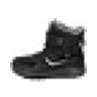

In [44]:
X_sample = X_train[0].reshape(28,28)
plt.figure(figsize=(1,1))
plt.imshow(X_sample, cmap="binary")
plt.axis('off')
plt.show()

In [45]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [46]:
class_names[y_train[0]]

'Ankle boot'

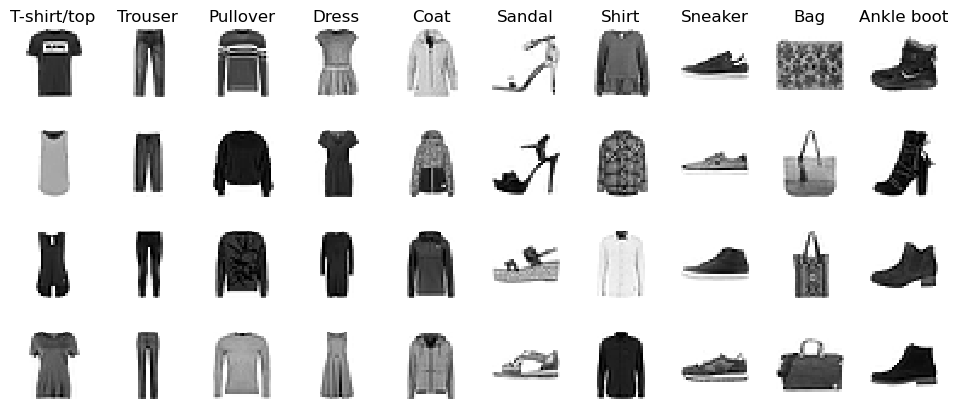

In [47]:
n_rows = 4
plt.figure(figsize=(12, n_rows*1.2))
for row in range(n_rows):
    for class_index in range(10):
        X_img = X_train[y_train==class_index][row].reshape(28, 28)
        y_img = y_train[y_train==class_index][row]
        plt.subplot(n_rows, 10, 10 *row + class_index + 1)
        plt.imshow(X_img, cmap="binary", interpolation="nearest")
        plt.axis('off')
        if row == 0:
            plt.title(class_names[y_img])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [48]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

mlp_clf = MLPClassifier(hidden_layer_sizes=[200, 200], early_stopping=True, verbose=True)
pipeline = make_pipeline(MinMaxScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_test, y_test)

Iteration 1, loss = 0.54712653
Validation score: 0.845833
Iteration 2, loss = 0.38384090
Validation score: 0.854000
Iteration 3, loss = 0.33831312
Validation score: 0.865833
Iteration 4, loss = 0.31530600
Validation score: 0.861667
Iteration 5, loss = 0.29367918
Validation score: 0.876667
Iteration 6, loss = 0.28186014
Validation score: 0.871500
Iteration 7, loss = 0.26790407
Validation score: 0.876833
Iteration 8, loss = 0.25408059
Validation score: 0.881167
Iteration 9, loss = 0.24563003
Validation score: 0.879667
Iteration 10, loss = 0.23308977
Validation score: 0.884833
Iteration 11, loss = 0.22404384
Validation score: 0.876000
Iteration 12, loss = 0.21722146
Validation score: 0.889500
Iteration 13, loss = 0.20783645
Validation score: 0.883667
Iteration 14, loss = 0.19898880
Validation score: 0.892667
Iteration 15, loss = 0.19438870
Validation score: 0.875500
Iteration 16, loss = 0.18509204
Validation score: 0.890500
Iteration 17, loss = 0.18195191
Validation score: 0.889833
Iterat

In [49]:
accuracy

0.8885

In [50]:
mlp_clf.best_validation_score_

0.8943333333333333

In [51]:
y_hat = pipeline.predict(X_test)

In [52]:
y_test

array([9, 2, 1, ..., 8, 1, 5], shape=(10000,))

              precision    recall  f1-score   support

           0       0.88      0.77      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.81      0.83      0.82      1000
           3       0.91      0.88      0.89      1000
           4       0.77      0.87      0.82      1000
           5       0.98      0.96      0.97      1000
           6       0.71      0.72      0.71      1000
           7       0.92      0.97      0.94      1000
           8       0.98      0.97      0.98      1000
           9       0.97      0.94      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



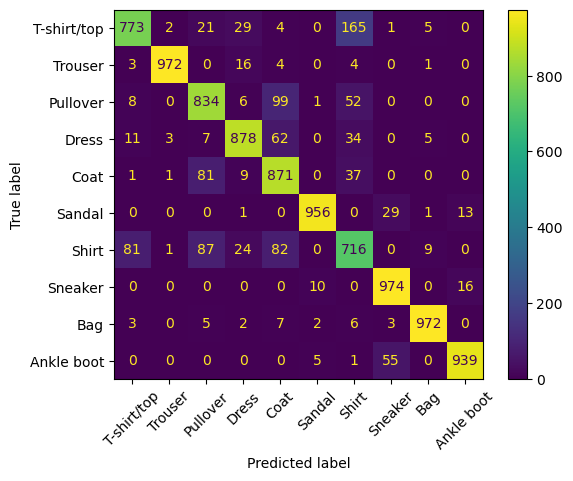

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_hat)
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(xticks_rotation=45)
print(classification_report(y_test, y_hat))